# Py - RTTOV

[PDF Python Interface Guide - NWP/SAF](https://nwp-saf.eumetsat.int/site/download/documentation/rtm/docs_rttov12/rttov-wrapper.pdf)



In [1]:
# System information
import numpy as np
import matplotlib.pyplot as plt
import os, sys, glob
import pandas as pd
import xarray
import h5py
import pickle
import netCDF4 as nc
import multiprocessing
from functools import partial
import datetime
from scipy import stats


pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
plt.rcParams['figure.figsize'] = [12, 8]

# System information
def to_days_since(time):
    reference = datetime.datetime(1900, 1, 1)
    fstart = datetime.datetime(int(str(time)[:4]),int(str(time)[-2:]),15)
    offset = fstart - reference
    return offset.days

import warnings
warnings.filterwarnings('ignore')

/tmp/ipykernel_3600660/4183239457.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def calc_anomaly(re, da, mean_preset = None):
    re_c = re.copy()
    if mean_preset == None:
        mean = [0]*12
        count = [0]*12
        for i in range(len(re_c)):
            if not np.isnan(re_c[i]):
                for j in range(1, 13):
                    if da[i].month == j:
                        mean[j-1] += re_c[i]
                        count[j-1] += 1
                        break
        for j in range(1,13):
                mean[j-1] = mean[j-1]/count[j-1]
    else:
        mean = mean_preset
    for i in range(len(re_c)):
        if not np.isnan(re_c[i]):
            for j in range(1,13):
                if da[i].month == j:
                    re_c[i] -= mean[j-1]
    return re_c, mean

In [3]:
def ano_plot(calc_data, calc_date, sat_data, sat_date, col, name):
    first = np.array(sat_data)
    first = first[~np.isnan(sat_data)]
    first_date = np.array(sat_date)[~np.isnan(sat_data)]
    second = calc_data[np.isin(calc_date, first_date)]
    first = first[~np.isnan(second)]
    second = second[~np.isnan(second)]
    person_corr_coeff = stats.pearsonr(first, second)

    resi = []
    for i in range(len(calc_data)):
        if calc_date[i] in sat_date:
            resi.append(calc_data[i] - sat_data[sat_date == calc_date[i]])
        else:
            resi.append(np.nan)

    fig, ax = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax[0].grid()
    ax[0].set(ylabel='brightness temperature [K]',
       title='anomaly_' + name + ' \n Pearson correlation coefficient '+str(person_corr_coeff[0]))
    ax[0].plot(sat_date, sat_data, color=col, label='satellite_' + name, linewidth=4, alpha=0.4)
    ax[0].plot(calc_date, calc_data, color=col, label='rttov_' + name, linewidth=2, alpha=0.8)
    ax[0].legend()
    ax[1].set(xlabel='date', ylabel='brightness temperature [K]')
    ax[1].grid()
    ax[1].plot(calc_date, resi,'--', color=col, label='residual', linewidth=2, alpha=0.8)
    ax[1].legend()
    fig.tight_layout(pad=2.0)
    plt.show()

In [4]:
def bt_plot(calc_datalist, calc_datelist, sat_datalist, sat_datelist, chan, name):
    fig, ax = plt.subplots()
    ax.grid()
    ax.set(xlabel='date', ylabel='brightness temperature [K]',
       title=name)
    col = ['red', 'blue', 'green']
    for i in range(len(calc_datalist)):
        ax.plot(sat_datelist[i], sat_datalist[i], color=col[i], label='satellite_'+name+'_'+str(chan + i), linewidth=4, alpha=0.4)
        ax.plot(calc_datelist[i], calc_datalist[i], color=col[i], label='rttov_'+name+'_'+str(chan + i), linewidth=2, alpha=0.8)
    ax.legend()
    fig.tight_layout(pad=2.0)
    plt.show()
    plt.close()

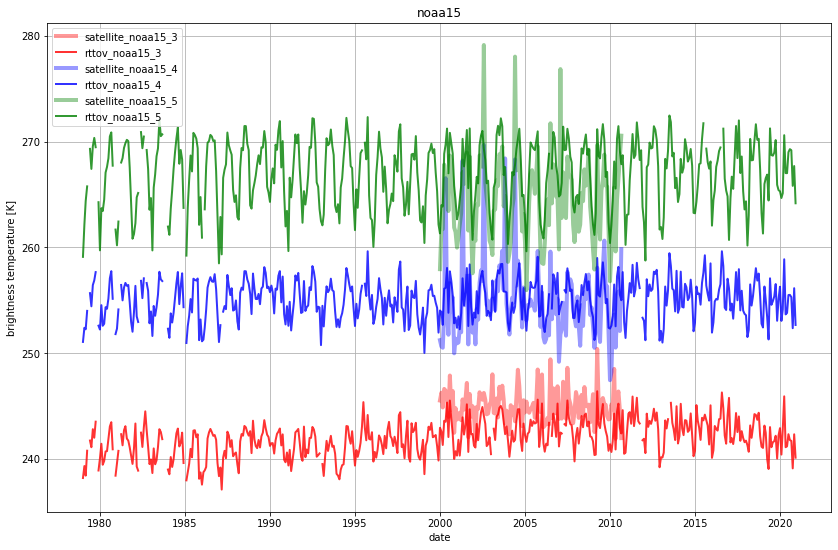

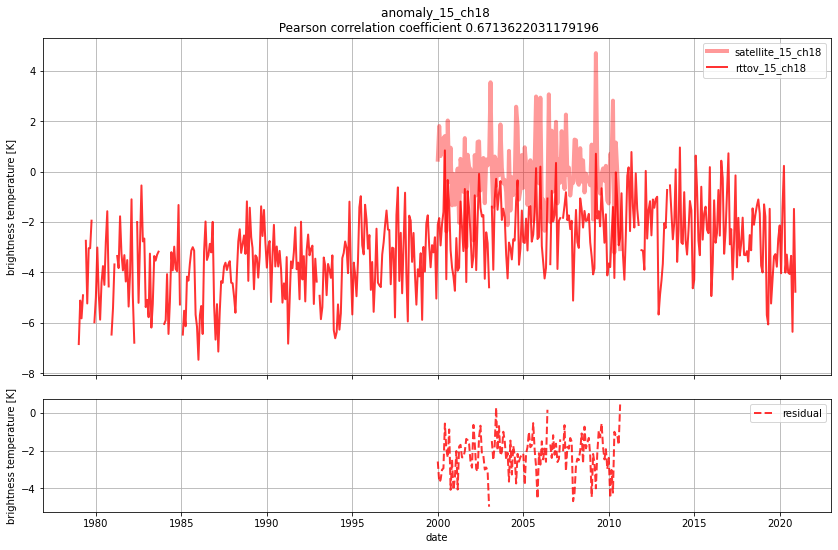

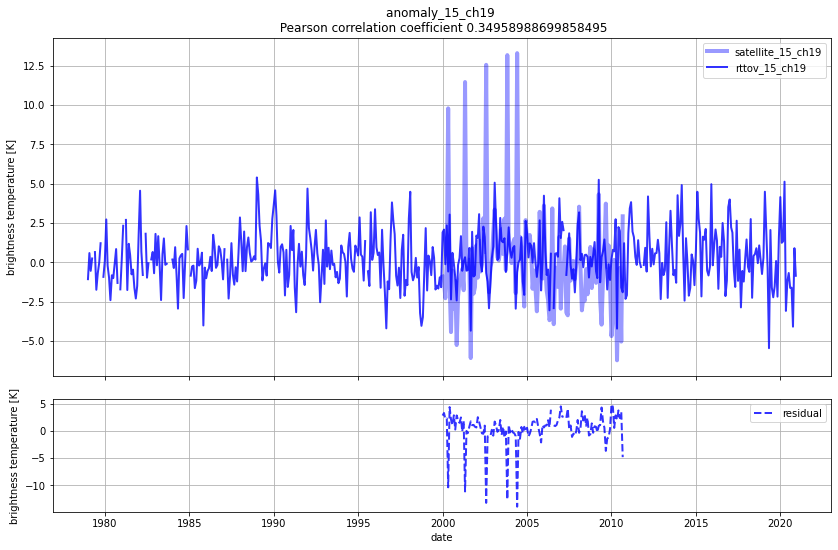

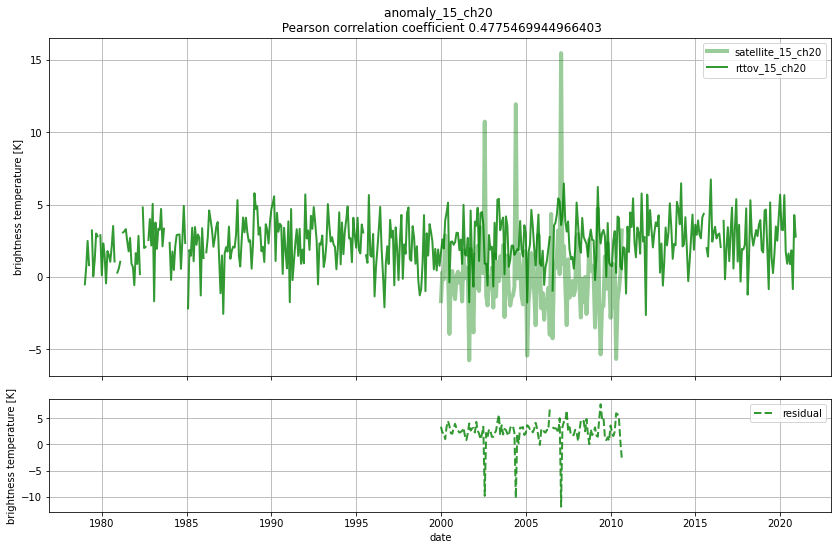

In [5]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_15_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_15_18 = refl[:,0]
refl_15_18[refl_15_18 > np.nanquantile(refl_15_18, 0.99)] = np.nan
refl_15_18[refl_15_18 < np.nanquantile(refl_15_18, 0.01)] = np.nan

dates_15_18 = []
for i in range(len(da)):
    dates_15_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_15_19 = refl[:,1]
refl_15_19[refl_15_19 > np.nanquantile(refl_15_19, 0.99)] = np.nan
refl_15_19[refl_15_19 < np.nanquantile(refl_15_19, 0.01)] = np.nan
dates_15_19 = dates_15_18

refl_15_20 = refl[:,2]
refl_15_20[refl_15_20 > np.nanquantile(refl_15_20, 0.99)] = np.nan
refl_15_20[refl_15_20 < np.nanquantile(refl_15_20, 0.01)] = np.nan
dates_15_20 = dates_15_18

a = glob.glob('./fiduceo/out/all_noaa15/'+stat+'/*')
a = np.sort(a)
refls_amsub15_18 = []
dates_amsub15_18 = []
refls_amsub15_19 = []
dists_amsub15_19 = []
times_amsub15_19 = []
dates_amsub15_19 = []
refls_amsub15_20 = []
dates_amsub15_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub15_18.append(refs[0])
        refls_amsub15_19.append(refs[1])
        refls_amsub15_20.append(refs[2])
        dists_amsub15_19.append(dists)
        times_amsub15_19.append(times)
    except:
        refls_amsub15_18.append(np.nan)
        refls_amsub15_19.append(np.nan)
        refls_amsub15_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub15_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub15_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub15_18, ano_mean_amsub15_18 = calc_anomaly(refls_amsub15_18, dates_amsub15_18)
ano_refls_amsub15_19, ano_mean_amsub15_19 = calc_anomaly(refls_amsub15_19, dates_amsub15_19)
ano_refls_amsub15_20, ano_mean_amsub15_20 = calc_anomaly(refls_amsub15_20, dates_amsub15_20)

ano_refl_15_18, ano_mean_15_18 = calc_anomaly(refl_15_18, dates_15_18, ano_mean_amsub15_18)
ano_refl_15_19, ano_mean_15_19 = calc_anomaly(refl_15_19, dates_15_19, ano_mean_amsub15_19)
ano_refl_15_20, ano_mean_15_20 = calc_anomaly(refl_15_20, dates_15_20, ano_mean_amsub15_20)


bt_plot(calc_datalist = [refl_15_18, refl_15_19, refl_15_20], 
        calc_datelist = [dates_15_18, dates_15_19, dates_15_20],
        sat_datalist = [refls_amsub15_18, refls_amsub15_19, refls_amsub15_20], 
        sat_datelist = [dates_amsub15_18, dates_amsub15_19, dates_amsub15_20],
        name = 'noaa15', chan = 3)

ano_plot(calc_data = np.array(ano_refl_15_18), calc_date = np.array(dates_15_18),
         sat_data = np.array(ano_refls_amsub15_18), sat_date = np.array(dates_amsub15_18),
         col = 'red', name = '15_ch18')
ano_plot(calc_data = np.array(ano_refl_15_19), calc_date = np.array(dates_15_19),
         sat_data = np.array(ano_refls_amsub15_19), sat_date = np.array(dates_amsub15_19),
         col = 'blue', name = '15_ch19')
ano_plot(calc_data = np.array(ano_refl_15_20), calc_date = np.array(dates_15_20),
         sat_data = np.array(ano_refls_amsub15_20), sat_date = np.array(dates_amsub15_20),
         col = 'green', name = '15_ch20')

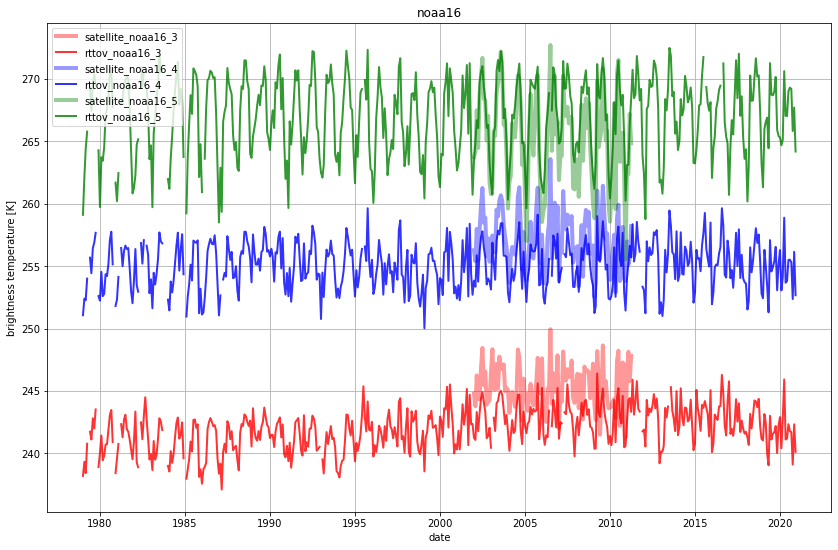

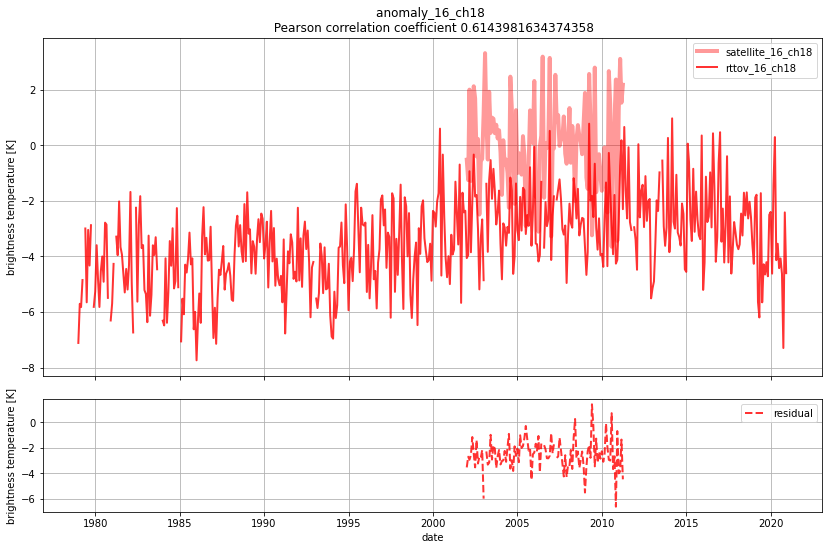

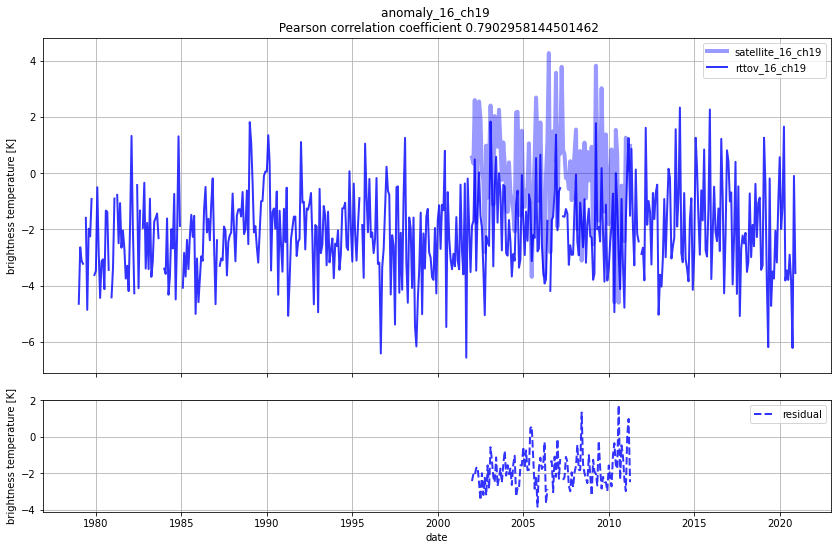

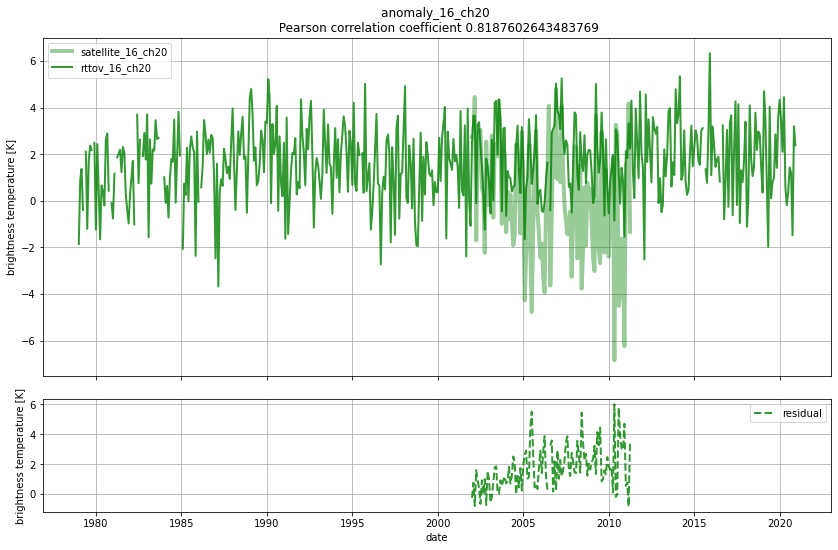

In [6]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_16_amsub/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_16_18 = refl[:,0]
refl_16_18[refl_16_18 > np.nanquantile(refl_16_18, 0.99)] = np.nan
refl_16_18[refl_16_18 < np.nanquantile(refl_16_18, 0.01)] = np.nan

dates_16_18 = []
for i in range(len(da)):
    dates_16_18.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_16_19 = refl[:,1]
refl_16_19[refl_16_19 > np.nanquantile(refl_16_19, 0.99)] = np.nan
refl_16_19[refl_16_19 < np.nanquantile(refl_16_19, 0.01)] = np.nan

dates_16_19 = dates_16_18

refl_16_20 = refl[:,2]
refl_16_20[refl_16_20 > np.nanquantile(refl_16_20, 0.99)] = np.nan
refl_16_20[refl_16_20 < np.nanquantile(refl_16_20, 0.01)] = np.nan

dates_16_20 = dates_16_18

a = glob.glob('./fiduceo/out/all_noaa16/'+stat+'/*')
a = np.sort(a)
refls_amsub16_18 = []
dates_amsub16_18 = []
refls_amsub16_19 = []
dates_amsub16_19 = []
refls_amsub16_20 = []
dates_amsub16_20 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_amsub16_18.append(refs[0])
        refls_amsub16_19.append(refs[1])
        refls_amsub16_20.append(refs[2])
    except:
        refls_amsub16_18.append(np.nan)
        refls_amsub16_19.append(np.nan)
        refls_amsub16_20.append(np.nan)
    date = i.split('_')[4:6]
    dates_amsub16_18.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_19.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_amsub16_20.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    
ano_refls_amsub16_18, ano_mean_amsub16_18 = calc_anomaly(refls_amsub16_18, dates_amsub16_18)
ano_refls_amsub16_19, ano_mean_amsub16_19 = calc_anomaly(refls_amsub16_19, dates_amsub16_19)
ano_refls_amsub16_20, ano_mean_amsub16_20 = calc_anomaly(refls_amsub16_20, dates_amsub16_20)

ano_refl_16_18, ano_mean_16_18 = calc_anomaly(refl_16_18, dates_16_18, ano_mean_amsub16_18)
ano_refl_16_19, ano_mean_16_19 = calc_anomaly(refl_16_19, dates_16_19, ano_mean_amsub16_19)
ano_refl_16_20, ano_mean_16_20 = calc_anomaly(refl_16_20, dates_16_20, ano_mean_amsub16_20)


bt_plot(calc_datalist = [refl_16_18, refl_16_19, refl_16_20], 
        calc_datelist = [dates_16_18, dates_16_19, dates_16_20],
        sat_datalist = [refls_amsub16_18, refls_amsub16_19, refls_amsub16_20], 
        sat_datelist = [dates_amsub16_18, dates_amsub16_19, dates_amsub16_20],
        name = 'noaa16', chan = 3)

ano_plot(calc_data = np.array(ano_refl_16_18), calc_date = np.array(dates_16_18),
         sat_data = np.array(ano_refls_amsub16_18), sat_date = np.array(dates_amsub16_18),
         col = 'red', name = '16_ch18')
ano_plot(calc_data = np.array(ano_refl_16_19), calc_date = np.array(dates_16_19),
         sat_data = np.array(ano_refls_amsub16_19), sat_date = np.array(dates_amsub16_19),
         col = 'blue', name = '16_ch19')
ano_plot(calc_data = np.array(ano_refl_16_20), calc_date = np.array(dates_16_20),
         sat_data = np.array(ano_refls_amsub16_20), sat_date = np.array(dates_amsub16_20),
         col = 'green', name = '16_ch20')

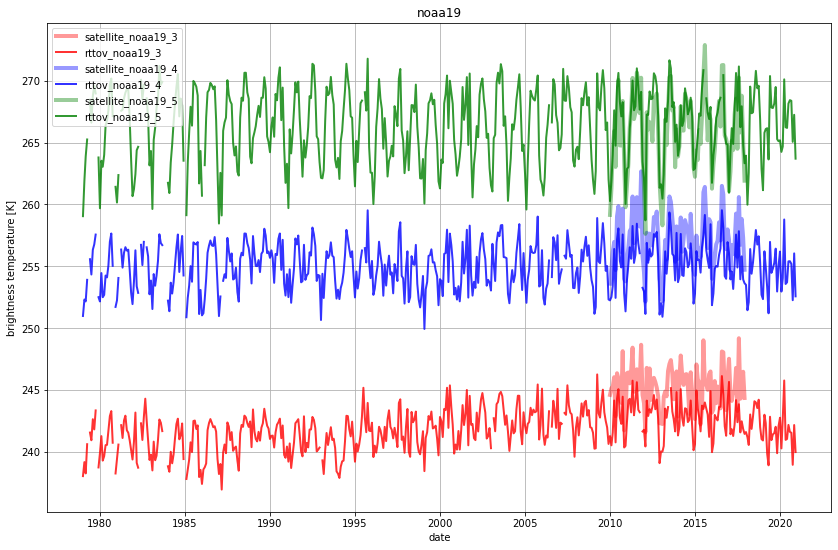

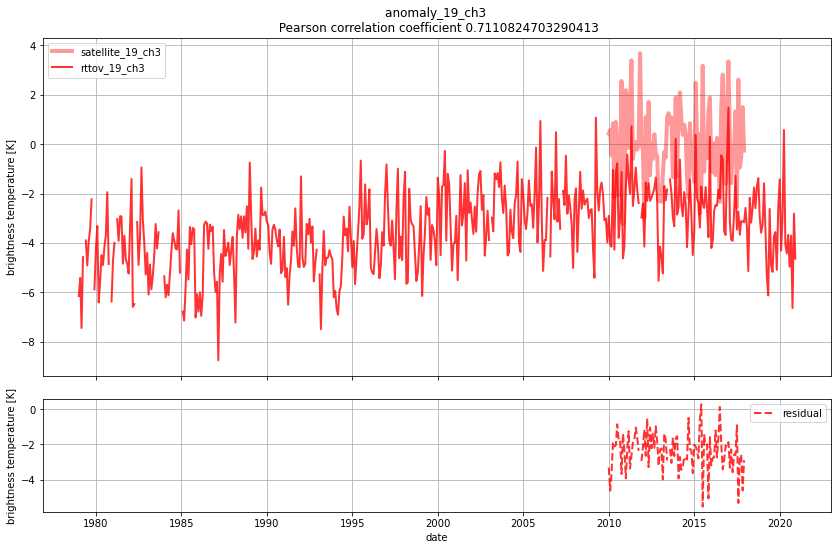

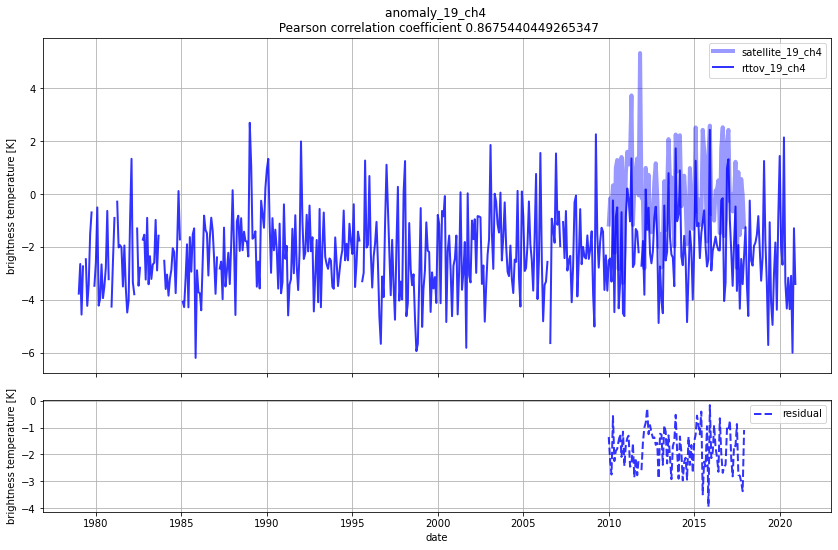

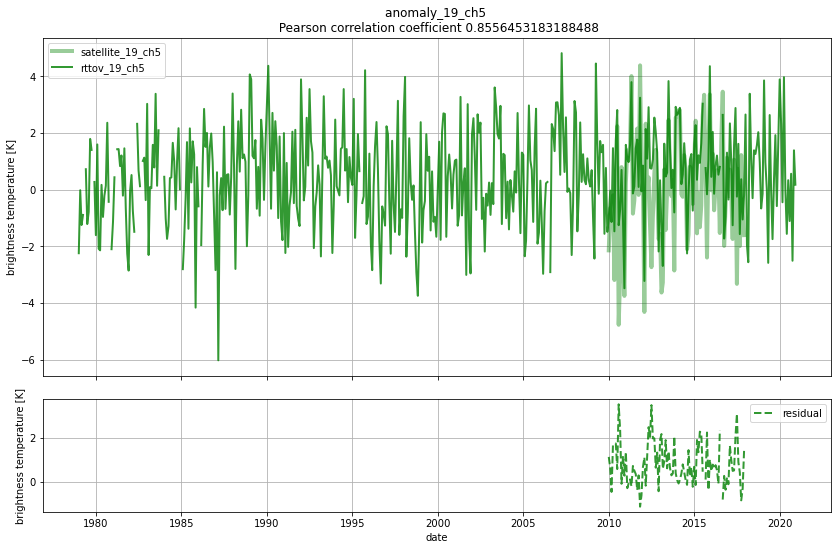

In [7]:
stat="11035"
re = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_refl.p", "rb" ) )
nre = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_night_refl.p", "rb" ) )
re = np.nanmean([re, nre], axis=0)
da = pickle.load( open( "./rttov_out_hum_noaa_19_mhs/"+stat+"/"+stat+"_day_dates.p", "rb" ) )
refl = np.resize(re,(len(re),3))
refl_19_3 = refl[:,0]
refl_19_3[refl_19_3 > np.nanquantile(refl_19_3, 0.99)] = np.nan
refl_19_3[refl_19_3 < np.nanquantile(refl_19_3, 0.01)] = np.nan
dates_19_3 = []
for i in range(len(da)):
    dates_19_3.append(pd.to_datetime(str(da[i])[:4]+'-'+str(da[i])[4:]))

refl_19_4 = refl[:,1]
refl_19_4[refl_19_4 > np.nanquantile(refl_19_4, 0.99)] = np.nan
refl_19_4[refl_19_4 < np.nanquantile(refl_19_4, 0.01)] = np.nan
dates_19_4 = dates_19_3

refl_19_5 = refl[:,2]
refl_19_5[refl_19_5 > np.nanquantile(refl_19_5, 0.99)] = np.nan
refl_19_5[refl_19_5 < np.nanquantile(refl_19_5, 0.01)] = np.nan
dates_19_5 = dates_19_3

a = glob.glob('./fiduceo/out/all_noaa19/'+stat+'/*')
a = np.sort(a)
refls_mhs19_3 = []
dates_mhs19_3 = []
refls_mhs19_4 = []
dates_mhs19_4 = []
refls_mhs19_5 = []
dates_mhs19_5 = []
for i in a[12:]:
    try:
        refs, times, dists = pickle.load( open( i, "rb" ) )
        refls_mhs19_3.append(refs[0])
        refls_mhs19_4.append(refs[1])
        refls_mhs19_5.append(refs[2])
    except:
        refls_mhs19_3.append(np.nan)
        refls_mhs19_4.append(np.nan)
        refls_mhs19_5.append(np.nan)
    date = i.split('_')[4:6]
    dates_mhs19_3.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_4.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))
    dates_mhs19_5.append(pd.to_datetime(date[0]+'-'+date[1]+'-'+'01'))

ano_refls_mhs19_3, ano_mean_mhs19_3 = calc_anomaly(refls_mhs19_3, dates_mhs19_3)
ano_refls_mhs19_4, ano_mean_mhs19_4 = calc_anomaly(refls_mhs19_4, dates_mhs19_4)
ano_refls_mhs19_5, ano_mean_mhs19_5 = calc_anomaly(refls_mhs19_5, dates_mhs19_5)

ano_refl_19_3, ano_mean_19_3 = calc_anomaly(refl_19_3, dates_19_3, ano_mean_mhs19_3)
ano_refl_19_4, ano_mean_19_4 = calc_anomaly(refl_19_4, dates_19_4, ano_mean_mhs19_4)
ano_refl_19_5, ano_mean_19_5 = calc_anomaly(refl_19_5, dates_19_5, ano_mean_mhs19_5) 
    
bt_plot(calc_datalist = [refl_19_3, refl_19_4, refl_19_5], 
        calc_datelist = [dates_19_3, dates_19_4, dates_19_5],
        sat_datalist = [refls_mhs19_3, refls_mhs19_4, refls_mhs19_5], 
        sat_datelist = [dates_mhs19_3, dates_mhs19_4, dates_mhs19_5],
        name = 'noaa19', chan = 3)

ano_plot(calc_data = np.array(ano_refl_19_3), calc_date = np.array(dates_19_3),
         sat_data = np.array(ano_refls_mhs19_3), sat_date = np.array(dates_mhs19_3),
         col = 'red', name = '19_ch3')
ano_plot(calc_data = np.array(ano_refl_19_4), calc_date = np.array(dates_19_4),
         sat_data = np.array(ano_refls_mhs19_4), sat_date = np.array(dates_mhs19_4),
         col = 'blue', name = '19_ch4')
ano_plot(calc_data = np.array(ano_refl_19_5), calc_date = np.array(dates_19_5),
         sat_data = np.array(ano_refls_mhs19_5), sat_date = np.array(dates_mhs19_5),
         col = 'green', name = '19_ch5')

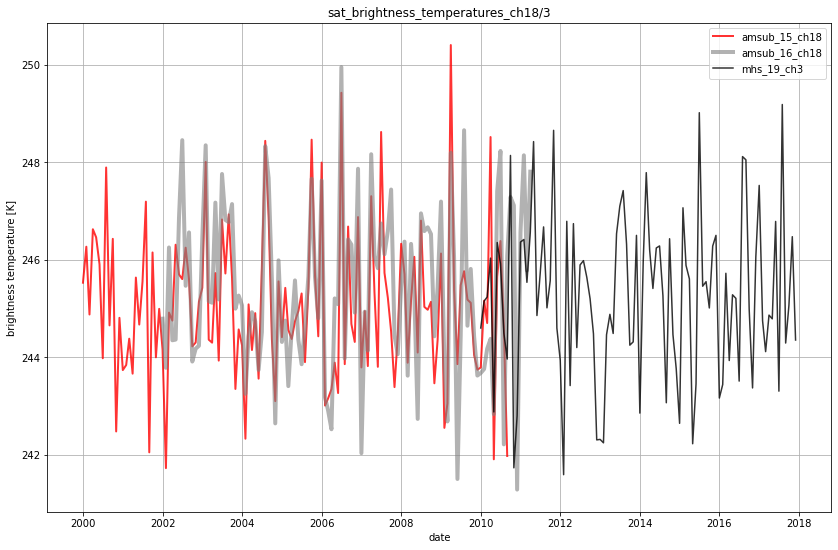

In [8]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch18/3')
ax.plot(dates_amsub15_18, refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, refls_amsub16_18, color='grey', label='amsub_16_ch18', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_3, refls_mhs19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

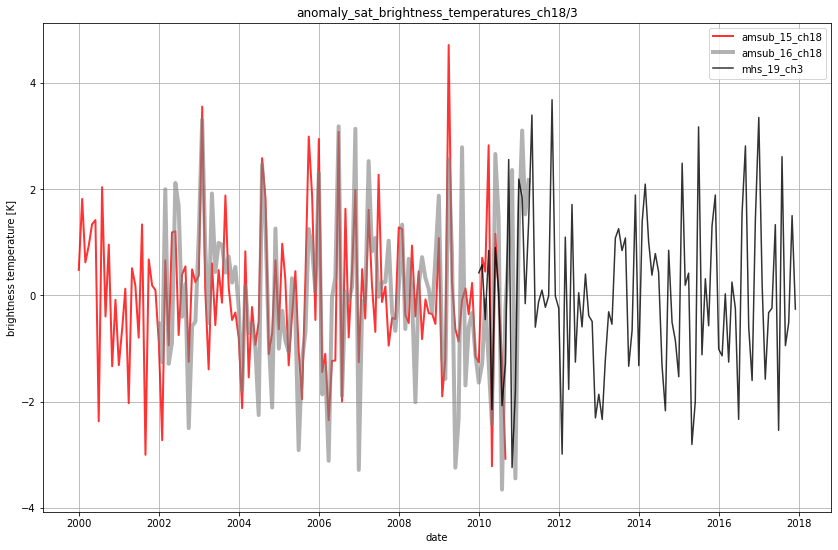

In [9]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch18/3')
ax.plot(dates_amsub15_18, ano_refls_amsub15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_18, ano_refls_amsub16_18, color='grey', label='amsub_16_ch18', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_3, ano_refls_mhs19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

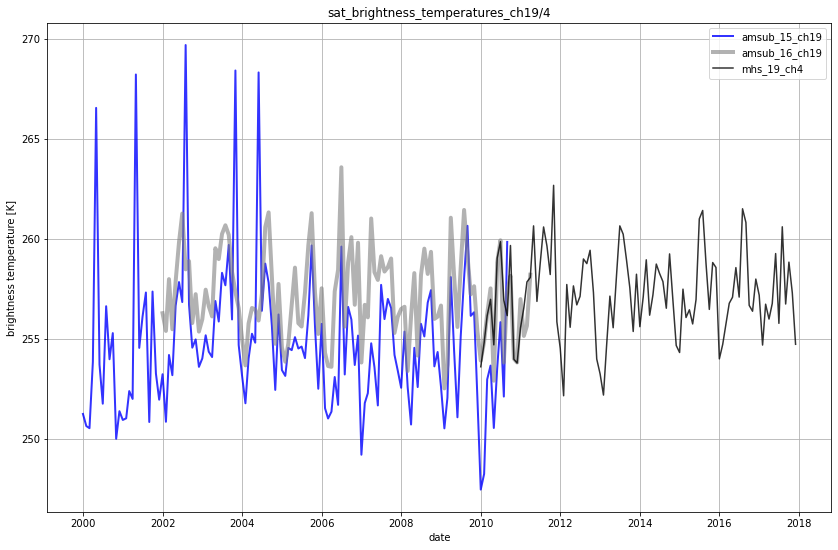

In [10]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

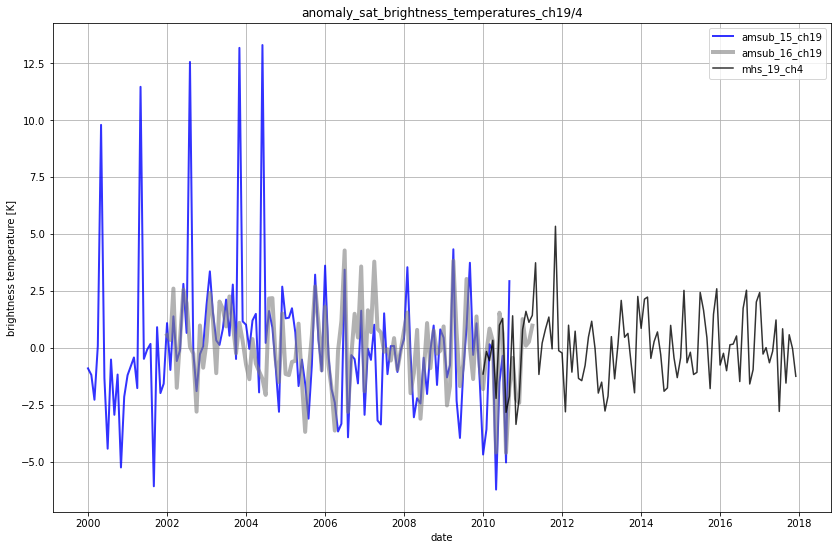

In [11]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, ano_refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, ano_refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, ano_refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

In [ ]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch19/4')

ax.plot(dates_amsub15_19, ano_refls_amsub15_19, color='blue', label='amsub_15_ch19', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_19, ano_refls_amsub16_19, color='grey', label='amsub_16_ch19', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_4, ano_refls_mhs19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

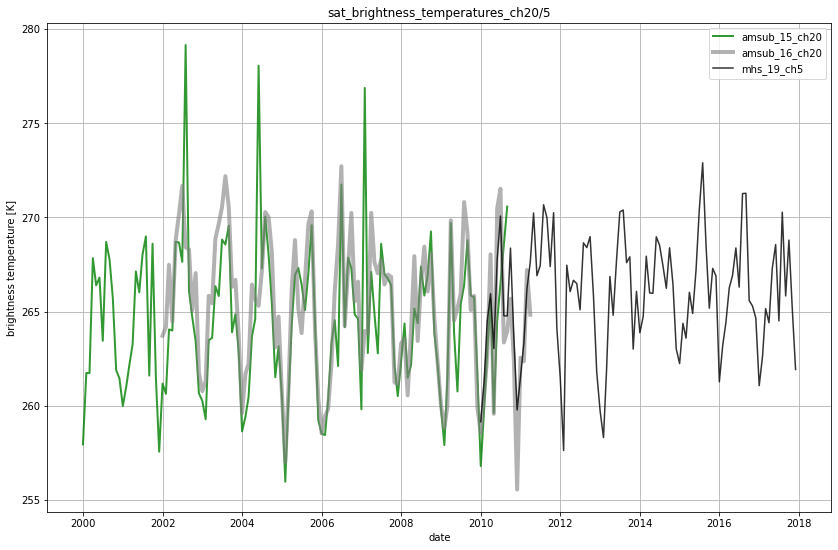

In [13]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='sat_brightness_temperatures_ch20/5')

ax.plot(dates_amsub15_20, refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_20, refls_amsub16_20, color='grey', label='amsub_16_ch20', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_5, refls_mhs19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

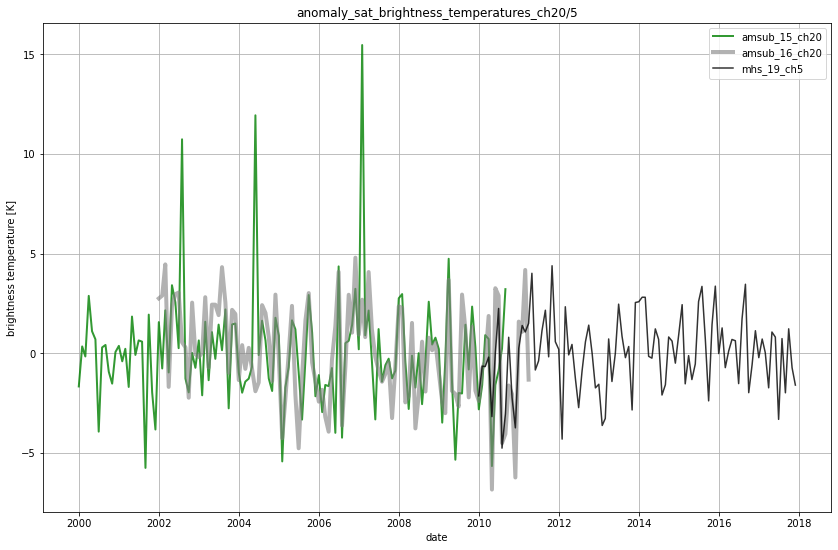

In [14]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_sat_brightness_temperatures_ch20/5')

ax.plot(dates_amsub15_20, ano_refls_amsub15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=0.8)
ax.plot(dates_amsub16_20, ano_refls_amsub16_20, color='grey', label='amsub_16_ch20', linewidth=4, alpha=0.6)
ax.plot(dates_mhs19_5, ano_refls_mhs19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

## RTTOV Comparison

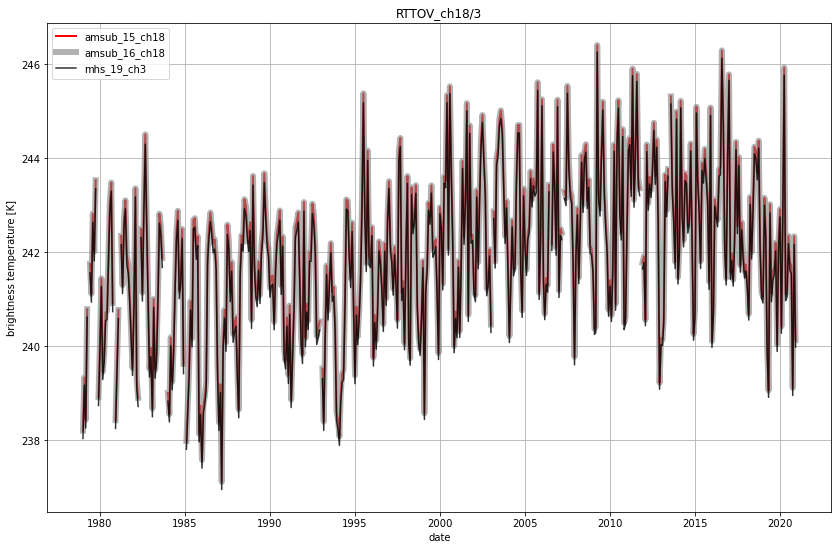

In [15]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch18/3')

ax.plot(dates_15_18, refl_15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_18, refl_16_18, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_3, refl_19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

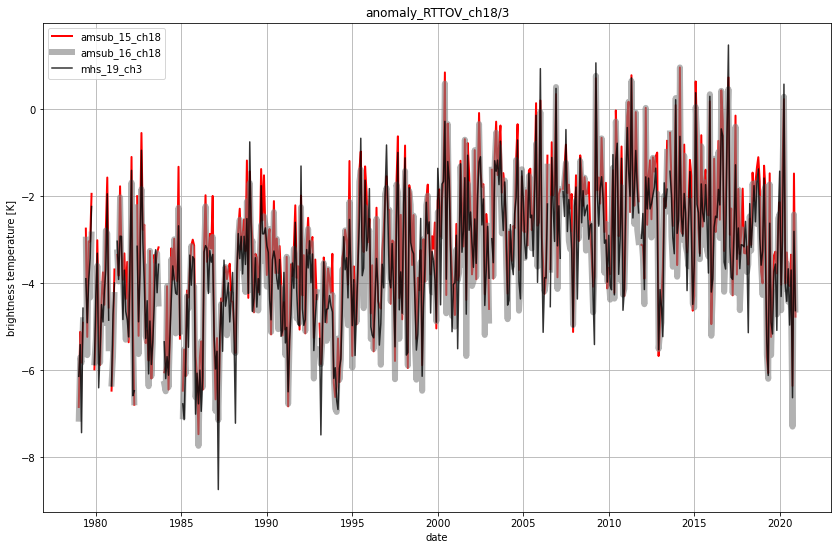

In [16]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch18/3')

ax.plot(dates_15_18, ano_refl_15_18, color='red', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_18, ano_refl_16_18, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_3, ano_refl_19_3, color='black', label='mhs_19_ch3', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

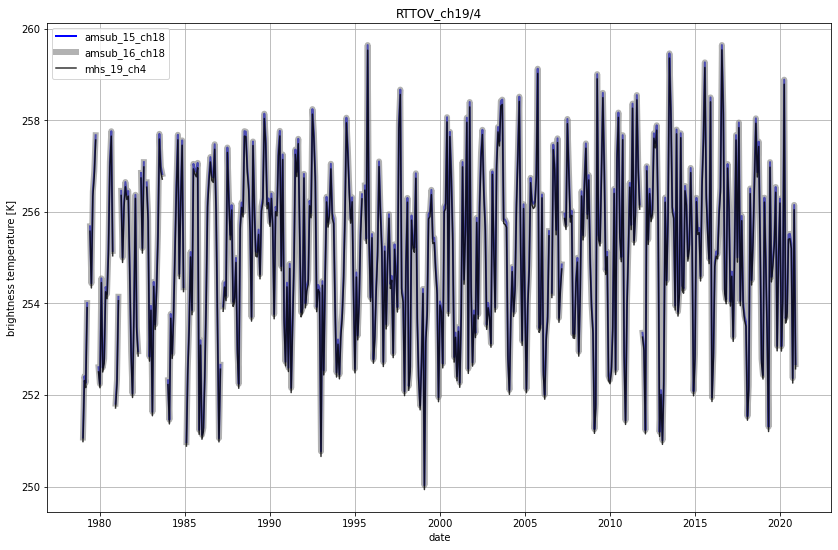

In [17]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch19/4')

ax.plot(dates_15_19, refl_15_19, color='blue', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_19, refl_16_19, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_4, refl_19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

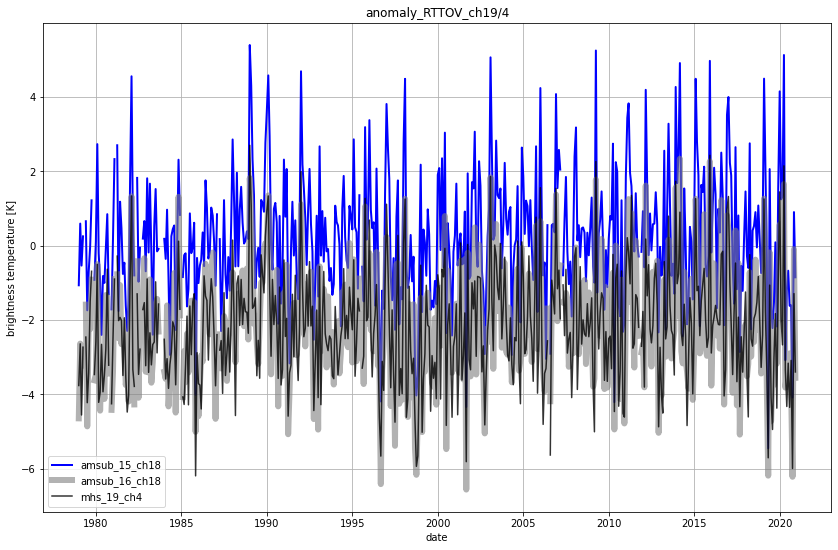

In [18]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch19/4')

ax.plot(dates_15_19, ano_refl_15_19, color='blue', label='amsub_15_ch18', linewidth=2, alpha=1)
ax.plot(dates_16_19, ano_refl_16_19, color='grey', label='amsub_16_ch18', linewidth=6, alpha=0.6)
ax.plot(dates_19_4, ano_refl_19_4, color='black', label='mhs_19_ch4', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

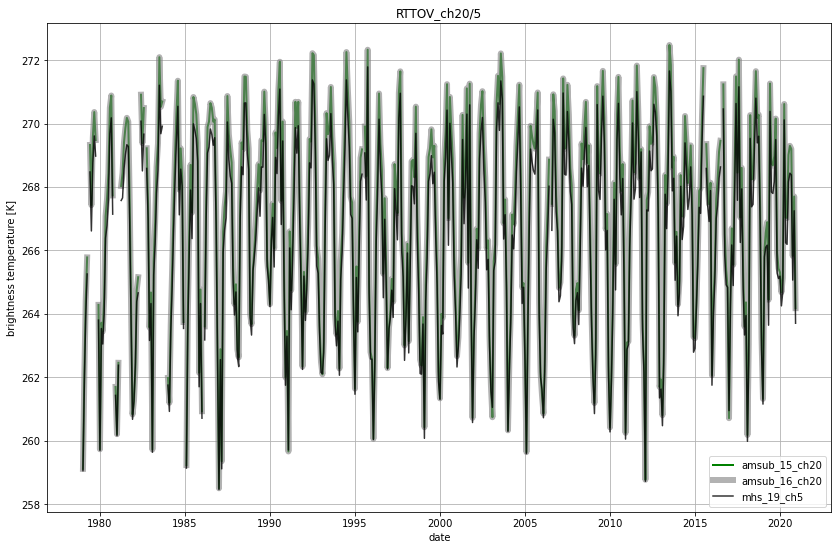

In [19]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='RTTOV_ch20/5')

ax.plot(dates_15_20, refl_15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=1)
ax.plot(dates_16_20, refl_16_20, color='grey', label='amsub_16_ch20', linewidth=6, alpha=0.6)
ax.plot(dates_19_5, refl_19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()

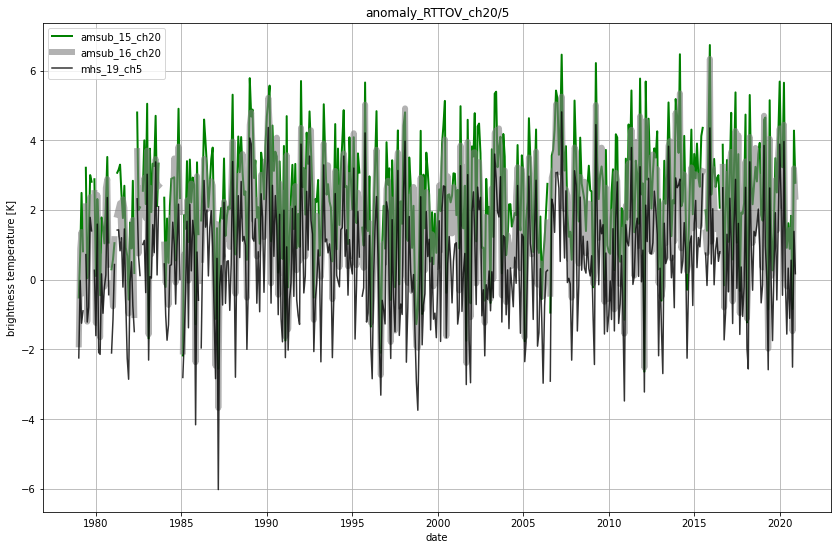

In [20]:
fig, ax = plt.subplots()
ax.grid()
ax.set(xlabel='date', ylabel='brightness temperature [K]',
   title='anomaly_RTTOV_ch20/5')

ax.plot(dates_15_20, ano_refl_15_20, color='green', label='amsub_15_ch20', linewidth=2, alpha=1)
ax.plot(dates_16_20, ano_refl_16_20, color='grey', label='amsub_16_ch20', linewidth=6, alpha=0.6)
ax.plot(dates_19_5, ano_refl_19_5, color='black', label='mhs_19_ch5', linewidth=1.5, alpha=0.8)

ax.legend()

fig.tight_layout(pad=2.0)
plt.show()
plt.close()